In [1]:
import networkx as nx
import qubovert as qv
import sympy
import matplotlib.pyplot as plt
from tqdm import tqdm
from arbitrage_helper import *

# Currency Arbitrage

Graph theory allow one to find an arbitrage opportunity, since there algorithms such as the Bellman-Ford algorithm that make negative cycle detection efficient. However, there is no guarantee that the negative cycle that this algorithm detects will be profitable. In this notebook, we will walk through how quantum techniques can find the most profitable arbitrage opportunity in a network of exhcange rates where rates aren't necessarily symmetrical.

If rates are symmetrical, there will be no arbitrage opportunity. However, occasionally for a brief moment, an opportunity to trade a string of currencies (e.g. USD for EUR for GBP for USD) can allow one to profit from an asymmetry in the exchange rates.

1QBIT has an excellent paper on this problem [here](https://1qbit.com/whitepaper/arbitrage/).

In [2]:
currency_abbreviations = ['USD', 'EUR', 'GBP', 'AUD', 'JPY', 'CAD', 'CHF', 'NZD']

In [3]:
# Create a directed graph with nodes as each currency
G = nx.DiGraph()
for currency in currency_abbreviations:
    G.add_node(currency)

In [4]:
for currency in range(len(currency_abbreviations)):
    base_currency = currency_abbreviations[currency]
    return_data = get_price_data(currency_abbreviations, currency)

    for i in range(len(return_data)):
        trading_from = currency_abbreviations[i]
        trading_to = base_currency
        price = return_data[i]
        # Exchange rate is 1.0 if it is the base currency; otherwise, add weighted, directed edge representing exchange rate
        # Exchange rate meaning example: for base currency of GBP, 0.83022 in USD column means trading 1 USD will deliver 0.83022 of the base currency
        # So add an edge from USD to GBP of weight 0.83022
        if price != 1.0:
            G.add_edge(trading_from, trading_to, weight=price)

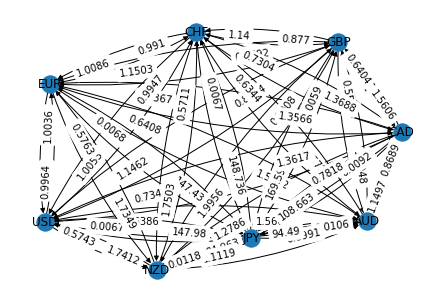

In [5]:
pos = nx.spring_layout(G, k=200, iterations=20)
labels = nx.get_edge_attributes(G,'weight')
for label in labels:
    labels[label] = round(labels[label], 4)
nx.draw(G, pos, with_labels=True, connectionstyle='arc3, rad = .1')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, label_pos=0.7)
plt.show()

Now that we have constructed the graph of exchange rates, we can create an objective function to optimize and find the most profitable sequence of trades to make.

In [6]:
qubo_dict = create_binary_variables(currency_abbreviations)
obj_P = create_objective_function(G, qubo_dict, currency_abbreviations)
obj_P, lam = add_constraints(qubo_dict, currency_abbreviations, obj_P)

route, value = solve(obj_P, lam, currency_abbreviations, qubo_dict, G)
return_dict = produce_best_trades(route, currency_abbreviations, G)
return_dict

{'trade_1': {'return': 1.0006277667552665,
  'trades': ['CHF', 'JPY', 'GBP', 'CAD', 'CHF']}}

Interpreting the result, we observe that we can trade 1 unit of the first currency through the series of trades back to the first currency and end up the return listed of the first currency.